In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import joblib
import json
import shap
import streamlit as st



In [10]:
# Configurar estilo dos gráficos
sns.set(style="whitegrid")

# 2. Carregar dados
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")


# 3. Pré-processamento
# Definir colunas
target = 'satisfaction'
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
num_cols = [col for col in train_df.columns if col not in cat_cols + [target, 'Unnamed: 0', 'id']]

# Separar features e target
X_train = train_df.drop(columns=[target, 'Unnamed: 0', 'id'])
y_train = train_df[target]
X_test = test_df.drop(columns=[target, 'Unnamed: 0', 'id'])
y_test = test_df[target]

# Criar pré-processador com tratamento de NaN
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Tratar NaN categóricos
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols),
        
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Tratar NaN numéricos
            ('scaler', StandardScaler())
        ]), num_cols)
    ])

# Aplicar transformações
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Verificar valores NaN
print("Valores faltantes após processamento:")
print(f"Treino: {np.isnan(X_train_processed).sum()}")
print(f"Teste: {np.isnan(X_test_processed).sum()}")




Valores faltantes após processamento:
Treino: 0
Teste: 0


In [11]:
from sklearn.preprocessing import LabelEncoder

# Criar encoder para a variável alvo
le = LabelEncoder()

# Aplicar transformação nos dados de treino e teste
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
joblib.dump(preprocessor, "models/preprocessor.pkl")

['models/preprocessor.pkl']

In [12]:
def train_and_evaluate_models(X_train, y_train_encoded, X_test, y_test_encoded):
    # Logistic Regression
    print("\n--- Logistic Regression ---")
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train_encoded) 
    y_pred = lr.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")

    # Decision Tree
    print("\n--- Decision Tree ---")
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train_encoded)  
    y_pred = dt.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")

    # Random Forest
    print("\n--- Random Forest ---")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train_encoded) 
    y_pred = rf.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")

    # XGBoost
    print("\n--- XGBoost ---")
    xgb_model = xgb.XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train, y_train_encoded)  
    y_pred = xgb_model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")

    # SVM com amostra reduzida
    print("\n--- SVM (Amostra Reduzida) ---")
    X_train_svm = X_train[:10000]
    y_train_svm = y_train_encoded[:10000] 
    svm_model = SVC(kernel='rbf', probability=True, random_state=42)
    svm_model.fit(X_train_svm, y_train_svm)
    y_pred = svm_model.predict(X_test[:3000])
    print(f"Accuracy: {accuracy_score(y_test_encoded[:3000], y_pred):.4f}")  

    # KNN
    print("\n--- KNN ---")
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train_encoded) 
    y_pred = knn.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")



In [13]:
train_and_evaluate_models(X_train_processed, y_train_encoded, X_test_processed, y_test_encoded)


--- Logistic Regression ---
Accuracy: 0.8718

--- Decision Tree ---
Accuracy: 0.9478

--- Random Forest ---
Accuracy: 0.9634

--- XGBoost ---
Accuracy: 0.9634

--- SVM (Amostra Reduzida) ---
Accuracy: 0.9390

--- KNN ---
Accuracy: 0.9292


In [14]:
from sklearn.preprocessing import LabelEncoder

# ------ PASSO 1: Codificar y ------
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# ------ PASSO 2: Treinar modelo ------
best_model = xgb.XGBClassifier(
    tree_method='hist',
    eval_metric='logloss',
    random_state=42,
    enable_categorical=True
).fit(X_train_processed, y_train_encoded)

# ------ PASSO 3: Salvar artefatos ------
joblib.dump(best_model, "models/xgb_final_model.pkl")
joblib.dump(le, "models/label_encoder.pkl")

with open("models/feature_columns.json", "w") as f:
    json.dump(preprocessor.get_feature_names_out().tolist(), f)

In [15]:
print("Classes originais:", le.classes_)  # Deve mostrar ['neutral or dissatisfied', 'satisfied']
print("Classes codificadas:", le.transform(le.classes_))  # Deve mostrar [0, 1]

Classes originais: ['neutral or dissatisfied' 'satisfied']
Classes codificadas: [0 1]


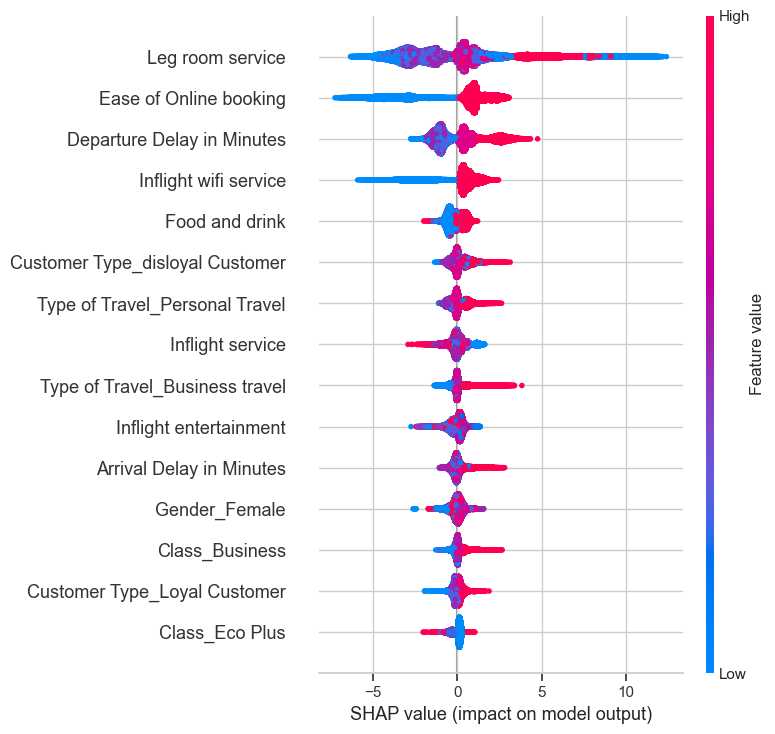

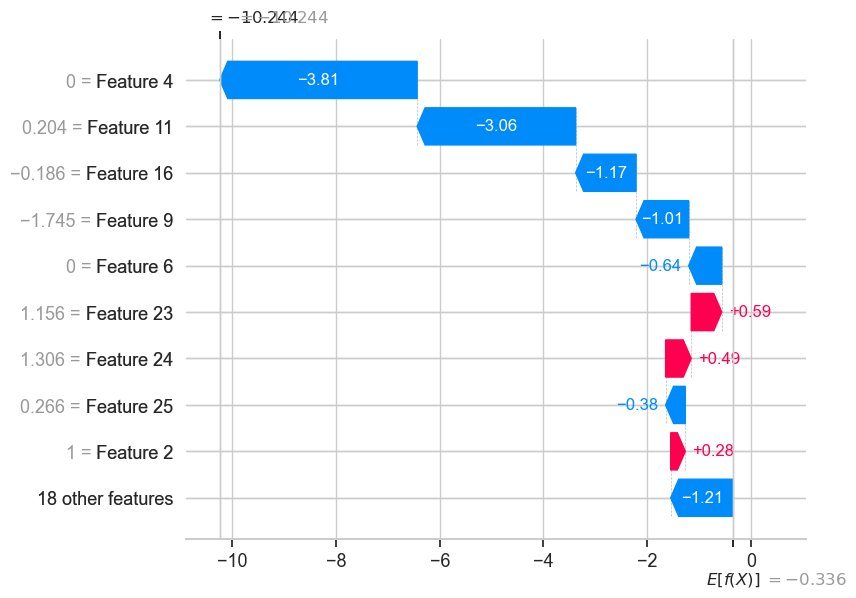

In [46]:
import numpy as np
# 1. Obter nomes das features após preprocessamento
num_features = num_cols
cat_features = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_features, cat_features])

# 2. Criar o explainer SHAP (para XGBoost, pode usar o Explainer padrão)
explainer = shap.Explainer(best_model)

# 3. Calcular valores SHAP para os dados processados
shap_values = explainer(X_train_processed)

# 4. Plotar gráfico summary
shap.summary_plot(shap_values, features=X_train_processed, feature_names=feature_names, max_display=15)
shap.plots.waterfall(shap_values[0])

In [19]:


# 8. Métricas finais
y_prob = best_model.predict_proba(X_test_processed)[:, 1]
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


ROC AUC Score: 0.9951


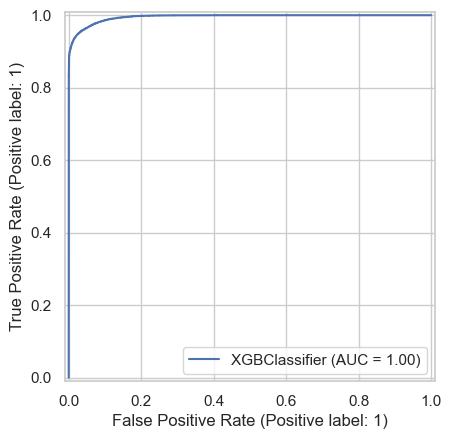

In [20]:
# Código corrigido
RocCurveDisplay.from_estimator(
    best_model, 
    X_test_processed, 
    y_test_encoded  # ✅ Usar valores codificados
)
plt.show()

In [21]:
# 9. Relatório final
le = joblib.load("models/label_encoder.pkl")  # Carregar encoder
y_pred = best_model.predict(X_test_processed)
y_pred_decoded = le.inverse_transform(y_pred)  # Converter para texto

print("\nRelatório de Classificação Final:")
print(classification_report(y_test, y_pred_decoded))  # ✅ Usar y_test e y_pred em texto


Relatório de Classificação Final:
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.97      0.94      0.96     11403

               accuracy                           0.96     25976
              macro avg       0.96      0.96      0.96     25976
           weighted avg       0.96      0.96      0.96     25976



In [22]:
import pandas as pd

# 1. Carregar o test.csv original
test_df = pd.read_csv("data/test.csv")

# 2. Remover colunas que não são usadas em produção
test_df_prod = test_df.drop(columns=['satisfaction', 'Unnamed: 0', 'id'], errors='ignore')

# 3. Salvar como test_1.csv
test_df_prod.to_csv("test_1.csv", index=False)

print("Arquivo 'test_1.csv' criado com sucesso!")


Arquivo 'test_1.csv' criado com sucesso!


In [23]:
# Mapear texto para números, mesmo que você tenha feito antes, só reforçando:
label_map = {'neutral or dissatisfied': 0, 'satisfied': 1}

# Transformar y_test para números (mesmo para treino já deve estar assim)
y_test_num = y_test.map(label_map)


In [24]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test_processed)

report = classification_report(y_test_num, y_pred, output_dict=True)

precision_satisfied = report['1']['precision'] * 100
print(f"Precisão (classe satisfeita): {precision_satisfied:.2f}%")


Precisão (classe satisfeita): 97.16%


In [25]:
recall_satisfied = report['1']['recall'] * 100
print(f"Recall (classe satisfeita): {recall_satisfied:.2f}%")


Recall (classe satisfeita): 94.43%


In [26]:
probas = best_model.predict_proba(X_test_processed)  # Use X_test_processed, NÃO X_test
confidences = np.max(probas, axis=1)
avg_confidence = np.mean(confidences) * 100

print(f"Confiança média: {avg_confidence:.2f}%")


Confiança média: 96.46%


In [30]:
import joblib
label_encoder = joblib.load("models/label_encoder.pkl")


In [36]:
import numpy as np
import joblib
import json

# Carregar recursos (se ainda não tiver carregado)
resources = {
    'model': joblib.load("models/xgb_final_model.pkl"),
    'preprocessor': joblib.load("models/preprocessor.pkl"),
    'label_encoder': joblib.load("models/label_encoder.pkl"),
    'features': json.load(open("models/feature_columns.json", 'r'))
}

# Obtenha as probabilidades preditas
probas = resources['model'].predict_proba(X_test_processed)

# Obtenha os índices das classes
classes = resources['label_encoder'].classes_

# Índice da classe positiva ("satisfied")
pos_class_index = np.where(classes == "satisfied")[0][0]

# Índice da classe negativa ("neutral or dissatisfied")
neg_class_index = np.where(classes == "neutral or dissatisfied")[0][0]

# Confiança média da classe positiva
pos_confidence = np.mean(probas[:, pos_class_index]) * 100

# Confiança média da classe negativa
neg_confidence = np.mean(probas[:, neg_class_index]) * 100

# Imprimir resultados
print(f"Confiança média da classe 'satisfied': {pos_confidence:.2f}%")
print(f"Confiança média da classe 'neutral or dissatisfied': {neg_confidence:.2f}%")



Confiança média da classe 'satisfied': 43.78%
Confiança média da classe 'neutral or dissatisfied': 56.22%


In [38]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Decodificar os rótulos reais para valores codificados
y_train_encoded = resources['label_encoder'].transform(y_train)
y_test_encoded = resources['label_encoder'].transform(y_test)

# Previsões
y_train_pred = best_model.predict(X_train_processed)
y_test_pred = best_model.predict(X_test_processed)

# Probabilidades para ROC AUC
y_train_proba = best_model.predict_proba(X_train_processed)[:, 1]
y_test_proba = best_model.predict_proba(X_test_processed)[:, 1]

# Métricas
print("📊 AVALIAÇÃO NO TREINO")
print(f"Acurácia: {accuracy_score(y_train_encoded, y_train_pred):.4f}")
print(f"F1-score: {f1_score(y_train_encoded, y_train_pred, pos_label=1):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train_encoded, y_train_proba):.4f}")

print("\n📉 AVALIAÇÃO NO TESTE")
print(f"Acurácia: {accuracy_score(y_test_encoded, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test_encoded, y_test_pred, pos_label=1):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_encoded, y_test_proba):.4f}")


📊 AVALIAÇÃO NO TREINO
Acurácia: 0.9749
F1-score: 0.9707
ROC AUC: 0.9979

📉 AVALIAÇÃO NO TESTE
Acurácia: 0.9634
F1-score: 0.9578
ROC AUC: 0.9951
